This notebook goes over how to plot the GHI error, WPD error, and Fitness from a single OptWRF model realization

Last Updated Oct 8, 2020

In [1]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

# Import the optwrf module
import optwrf
from optwrf import runwrf

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


## Plotting functions start here -----------------------------------------------------------------------

## -----------------------------------------------------------------------------------------------------

## Open files and create plots

In [12]:
# Verbose setting
verbose = True

# Define the datestr and paramstr
param_ids = [19, 4, 4, 7, 8, 99, 1]
start_date = 'Dec 13  2011'
end_date = 'Dec 14 2011'
datestr = '2011-12-13'
paramstr = '19mp4lw4sw7lsm8pbl99cu'
wrffile_name = f'wrfout_processed_d01_{datestr}_{paramstr}.nc'
wrffile_name_orig = f'wrfout_d01_{datestr}_{paramstr}.nc'

# Find the absolute file path to your optwrf package
optwrf_abspath = os.path.dirname(os.path.abspath(inspect.getfile(optwrf)))
optwrf_abspath

# Open the processed wrfout data
wrffile = os.path.join(optwrf_abspath, 'data', wrffile_name)
wrfdata = xr.open_dataset(wrffile)
if verbose:
    print(f'Processeed WRF DATA:\n{wrfdata}\n')
    
# Open the processed ERA5 data
erafile = os.path.join(optwrf_abspath, 'data', 'ERA5_EastUS_WPD-GHI_2011-12.nc')
eradata = xr.open_dataset(erafile)
if verbose:
    print(f'ERA5 DATA:\n{eradata}')

Processeed WRF DATA:
<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 ...
    wind_speed10    (Time, south

## Manual plotting (function dev) starts here ----------------------------------------------------------

In [28]:
# Regrid the wrf GHI and WPD
input_year = optwrf.helper_functions.format_date(datestr).strftime('%Y')
input_month = optwrf.helper_functions.format_date(datestr).strftime('%m')
wrf_dir = os.path.join(optwrf_abspath, 'data/')
era_dir = os.path.join(optwrf_abspath, 'data/')
wrfdata, eradata = optwrf.runwrf.wrf_era5_regrid_xesmf(input_year, 
                                                       input_month,
                                                       wrfdir=wrf_dir, 
                                                       eradir=era_dir)

The file name is: bilinear_191x191_97x129.nc and reuse_weights is: False


/Users/swardy9230/opt/anaconda3/envs/optwrf/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [31]:
# Calculate the error in GHI and WPD
wrfdata = optwrf.runwrf.wrf_era5_error(wrfdata, eradata)

In [32]:
wrfdata

<xarray.Dataset>
Dimensions:          (Time: 24, bottom_top: 35, lat: 97, lon: 129, south_north: 191, west_east: 191)
Coordinates:
  * Time             (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00
  * lon              (lon) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * lat              (lat) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times            (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00
    temp_air         (Time, south_north, west_east) float32 ...
    wind_speed_u     (Time, south_north, west_east) float32 ...
    wind_speed_v     (Time, south_north, west_east) float32 ...
    cloud_fraction   (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith       (Time, south_north, west_east) float32 ...
    dni              (Time, south_north, west_east) float32 ...
    dhi              (Time, south_north, west_east) float32 ...
    ghi              (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10     (Time, south_north, west_east) float32 ...
    wind_speed100    (Time, south_north, west_east) float32 ...
    wpd              (Time, south_north, west_east) float32 51001.94 ... 3622...
    ghi_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ghi_error        (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_error        (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    total_ghi_error  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    total_wpd_error  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

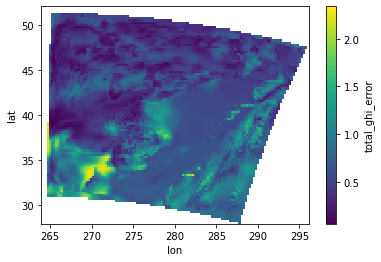

In [33]:
wrfdata.total_ghi_error.plot()

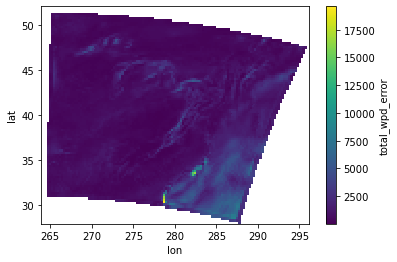

In [34]:
wrfdata.total_wpd_error.plot()

## OLD Plotting functions start here --------------------------------------------------------------------